Это baseline-ноутбук для проверки clipped-SGD и clipped-SSTM из статьи https://arxiv.org/pdf/2005.10785.pdf основанный на примере обучения классификатора на CIFAR10 https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

В данной версии уже обучается ResNet18 на ImageNet-100

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

In [2]:
data_path = "/run/media/kesha/1C84037484035026/kaggle/data"

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

input_size = 224
batch_size = 100
n_worker = 2

traindir = data_path + "/train"

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        traindir, transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])),
    batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True)

valdir = data_path + "/val"

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(int(input_size / 0.875)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker, pin_memory=True)

n_class = 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


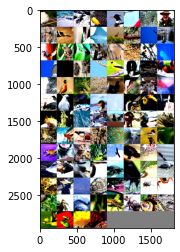

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

# net.to(device)

### Теперь напишем новые оптимизторы
из статьи https://arxiv.org/pdf/2005.10785.pdf

По большей части это основано на реализациях соответствующих оптимизаторов из библиотеки pytorch, см. 

https://github.com/pytorch/pytorch/tree/master/torch/optim

и, конкретно

https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py

https://github.com/pytorch/pytorch/blob/master/torch/optim/_functional.py

https://github.com/pytorch/pytorch/blob/master/torch/optim/optimizer.py

In [7]:
r"""Functional interface"""
import math
import torch
from torch import Tensor
from typing import List, Optional


def _make_sparse(grad, grad_indices, values):
    size = grad.size()
    if grad_indices.numel() == 0 or values.numel() == 0:
        return torch.empty_like(grad)
    return torch.sparse_coo_tensor(grad_indices, values, size)


def clipped_gradent_descent_step(
        params: List[Tensor], 
        d_p_list: List[Tensor], 
        lr: float,
        clipping_type: str,
        clipping_level: float):
    r"""Functional API that performs clipped step for slipped-SGD and clipped-SSTM algorithm 
        computation.
    See :class:`clipped_SGD` or class:`clipped_SSTM` for details.
    """
    grad_norm = 0.0
    if clipping_type == 'norm':
        for i in range(len(params)):
            grad_norm += d_p_list[i].norm() ** 2
        grad_norm = grad_norm ** 0.5
    
    for i, param in enumerate(params):
        d_p = d_p_list[i]

        if clipping_type == 'no_clip':
            param.add_(d_p, alpha=-lr)
        elif clipping_type == 'norm':
            alpha = min(1, clipping_level / grad_norm)
            param.add_(d_p, alpha=-lr*alpha)
        elif clipping_type == 'layer_wise':
            alpha = min(1, clipping_level / d_p.norm())
            param.add_(d_p, alpha=-lr*alpha)
        elif clipping_type == 'coordinate_wise':
            eps = 1e-10
            alpha = torch.clip(clipping_level / (torch.abs(d_p) + eps), min=0, max=1)
            param.add_(-lr * alpha * d_p)

In [8]:
import torch
from torch.optim import Optimizer


class _RequiredParameter(object):
    """Singleton class representing a required parameter for an Optimizer."""
    def __repr__(self):
        return "<required parameter>"

required = _RequiredParameter()

class _DependingParameter(object):
    """Singleton class representing a parameter that depends on other for an Optimizer."""
    def __init__(self, other_parameter_name):
        self.other_parameter_name = other_parameter_name

    def __repr__(self):
        return "<depends on {}>".format(self.other_parameter_name)

depending = _DependingParameter

class clipped_SGD(Optimizer):
    r"""Implements clipped version of stochastic gradient descent
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        clipping_type (string, optional): type of clipping to use: 'norm'|'layer_wise'|'coordinate_wise'.
            'no_clip': no clipping, standart sgd;
            'norm': standard clipping, \min\{1,\lambda / \|\nabla f(x)\|\} \nabla f(x);
            'layer_wise': standard clipping but it is calculated for each layer independently;
            'coordinate_wise': coordinate wise clipping, \min\{1_n, \lambda / \nabla f(x)\} \nabla f(x) 
            where all operations are coordinate wise. (Default: 'norm')
        clipping_level (float, optional): level of clipping \lambda (see clipping_type for more information). 
            Default value depends on clipping_type: 
            for clipping_type='norm' default clipping_level=10
            for clipping_type='layer_wise' default clipping_level=10
            for clipping_type='coordinate_wise' default clipping_level=0.5
    Example:
        >>> optimizer = torch.optim.clipped_SGD(model.parameters(), lr=0.01, 
                                                clipping_type='layer_wise', clipping_level=10)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=required, clipping_type='norm', clipping_level=depending('clipping_type')):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        type_to_default_level = {
            'no_clip': 0.0,
            'norm': 10,
            'layer_wise': 10,
            'coordinate_wise': 0.5
        }
        if clipping_type not in type_to_default_level:
            raise ValueError("Invalid clipping type: {}, possible types are {}".\
                             format(lr, list(type_to_default_level.keys())))
        if not isinstance(clipping_level, depending) and clipping_level < 0.0:
            raise ValueError("Invalid clipping level: {}".format(clipping_level))
        if isinstance(clipping_level, depending):
            clipping_level = type_to_default_level[clipping_type]
        defaults = dict(lr=lr, clipping_type=clipping_type, clipping_level=clipping_level)
        super(clipped_SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(clipped_SGD, self).__setstate__(state)

    @torch.no_grad() # sets all requires_grad flags to False
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            lr = group['lr']
            clipping_type = group['clipping_type']
            clipping_level = group['clipping_level']

            for p in group['params']:
                if p.grad is not None:
                    d_p_list.append(p.grad)
                    params_with_grad.append(p)

            clipped_gradent_descent_step(
                params_with_grad, 
                d_p_list, 
                lr, 
                clipping_type, 
                clipping_level)

        return loss


class clipped_SSTM(Optimizer):
    r"""Implements Clipped Stochastic Similar Triangles Method from https://arxiv.org/pdf/2005.10785.pdf
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (stepsize parameter a in paper, inverse to real lr)
        L (float): Lipschitz constant
        clipping_type (string, optional): type of clipping to use: 'norm'|'layer_wise'|'coordinate_wise'.
            'no_clip': no clipping, standart sgd;
            'norm': standard clipping, \min\{1,\lambda / \|\nabla f(x)\|\} \nabla f(x);
            'layer_wise': standard clipping but it is calculated for each layer independently;
            'coordinate_wise': coordinate wise clipping, \min\{1_n, \lambda / \nabla f(x)\} \nabla f(x) 
            where all operations are coordinate wise. (Default: 'norm')
        clipping_level (float, optional): level of clipping \lambda (see clipping_type for more information). 
            In this variant the clipping level changes, and clipping_level is used to calculate it
            Default value depends on clipping_type: 
            for clipping_type='norm' default clipping_level=10
            for clipping_type='layer_wise' default clipping_level=10
            for clipping_type='coordinate_wise' default clipping_level=0.5
    Example:
        >>> optimizer = torch.optim.clipped_SSTM(model.parameters(), lr=0.01, L=10,
                                                 clipping_type='norm', clipping_level=10)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=required, L=required, clipping_type='norm', clipping_level=depending('clipping_type')):
        if lr is not required and lr <= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if L is not required and L < 0.0:
            raise ValueError("Invalid Lipschitz constant: {}".format(lr))
        
        type_to_default_level = {
            'no_clip': 0.0,
            'norm': 10,
            'layer_wise': 0.1,
            'coordinate_wise': 0.5
        }
        if clipping_type not in type_to_default_level:
            raise ValueError("Invalid clipping type: {}, possible types are {}".\
                             format(lr, list(type_to_default_level.keys())))
        if not isinstance(clipping_level, depending) and clipping_level < 0.0:
            raise ValueError("Invalid clipping level: {}".format(clipping_level))
        if isinstance(clipping_level, depending):
            clipping_level = type_to_default_level[clipping_type]
        a = 1 / lr
        defaults = dict(a=a, L=L, clipping_type=clipping_type, clipping_level=clipping_level, state=dict())
        super(clipped_SSTM, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(clipped_SSTM, self).__setstate__(state)

    @torch.no_grad() # sets all requires_grad flags to False
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            a = group['a']
            L = group['L']
            clipping_type = group['clipping_type']
            clipping_level = group['clipping_level']

            state = group['state']
            # Lazy state initialization
            if len(state) == 0:
                state['k'] = 0
                state['alpha_k_1'] = 0
                state['lambda_k_1'] = 0
                state['A_k'] = 0
                state['A_k_1'] = 0

                state['y_k'] = []
                state['z_k'] = []
                for p in group['params']:
                    if p.grad is not None:
                        state['y_k'].append(p.data)
                        state['z_k'].append(p.data)
                
            k = state['k']
            alpha_k_1 = state['alpha_k_1']
            lambda_k_1 = state['lambda_k_1']
            A_k = state['A_k']
            A_k_1 = state['A_k_1']
            y_k = [y.data for y in state['y_k']]
            z_k = [z.data for z in state['z_k']]

            if k > 0:
                for p in group['params']:
                    if p.grad is not None:
                        # params_with_grad.append(p) # Это нам не нужно т.к. мы уже не меняем 
                        # параметры напрямую отнимая градиент - мы меняем веса суммой, см ниже
                        d_p_list.append(p.grad)

                # calculate z_{k+1}
                clipped_gradent_descent_step(
                    z_k, 
                    d_p_list, 
                    alpha_k_1, 
                    clipping_type, 
                    lambda_k_1)

                for i, p in enumerate(group['params']):
                    if p.grad is not None:
                        y_k[i] = (A_k * y_k[i].data + alpha_k_1 * z_k[i].data) / A_k_1

            # k_1 means "k + 1", so alpha_k_1 means \alpha_{k+1}
            alpha_k_1 = (k + 2) / (2 * a * L)
            A_k = state['A_k_1']
            A_k_1 = A_k + alpha_k_1
            lambda_k_1 = clipping_level / alpha_k_1

            #update x_{k+1}
            for i, p in enumerate(group['params']):
                if p.grad is not None:
                    p = (A_k * state['y_k'][i].data + alpha_k_1 * state['z_k'][i].data) / A_k_1

            state['k'] += 1
            state['alpha_k_1'] = alpha_k_1
            state['lambda_k_1'] = lambda_k_1
            state['A_k'] = A_k
            state['A_k_1'] = A_k_1

            state['y_k'] = y_k
            state['z_k'] = z_k

        return loss

### Протестируем их + сравним с SGD который используется в примере
вот в этом примере https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [9]:
traindir = data_path + "/train"

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        traindir, transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])),
    batch_size=batch_size, shuffle=True,
    num_workers=n_worker, pin_memory=True)

valdir = data_path + "/val"

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(int(input_size / 0.875)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=n_worker, pin_memory=True)

n_class = 100

classes = [i for i in range(1, 101)]

In [10]:
import torch.nn as nn
import torch.optim as optim

nets = [models.resnet18(), models.resnet18(), models.resnet18()]

criterion = nn.CrossEntropyLoss()

opts = [
    clipped_SSTM(nets[0].parameters(), lr=0.1, L=100, clipping_type='norm'),
    clipped_SGD(nets[1].parameters(), lr=0.1, clipping_type='norm'),
    optim.SGD(nets[2].parameters(), lr=0.1, momentum=0.9)
]

opt_names = [ 
    "clipped_SSTM, 0.1, 100, norm", 
    "clipped_SGD, 0.1, norm",
    "SGD, 0.1, 0.9"
]

hist = []

for (net, optimizer, opt_name) in zip(nets, opts, opt_names):
    net.to(device)

    hist.append({
        "name": opt_name, 
        "train_loss": [], "train_x": [], 
        "val_loss": [], "val_x": [], 
        "train_acc_top_1": [], "train_acc_top_5": [], 
        "val_acc_top_1": [], "val_acc_top_5": [], 
        "epochs_x": [],
        "total_steps": 0
    })

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def smooth(a, eps=0.01):
    b = [a[0]]
    for e in a[1:]:
        b.append(b[-1] * (1 - eps) + e * eps)
    return b


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def make_loss_plot(ax, hist, eps=0.01, alpha=0.5):
    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]
        train_y, train_x = one_optim_hist["train_loss"], one_optim_hist["train_x"]
        val_y, val_x = one_optim_hist["val_loss"], one_optim_hist["val_x"]
        epochs_x = one_optim_hist["epochs_x"]

        if len(train_x) == 0:
            continue

        ax.plot(
            train_x, smooth(train_y, eps=eps), 
            label=label + " (train)", 
            alpha=alpha, color=colors[i], linestyle="-"
        )
        if len(val_x) > 0:
            ax.plot(
                val_x, val_y, 
                label=label + " (val)", 
                alpha=alpha, color=colors[i], linestyle="--"
            )

        #epoch sep lines
        for x in epochs_x:
            ax.axvline(x, linestyle="--", color=colors[i], alpha=0.2)

    ax.set_title("logloss на train и val для разных оптимизаторов")
    ax.set_ylabel("logloss")
    ax.set_xlabel("Число итераций")
    ax.grid(True)
    ax.legend()

    return ax

def make_accuracy_plot(ax, hist, eps=0.01, alpha=0.5, top_k=1):
    for i, one_optim_hist in enumerate(hist):
        label = one_optim_hist["name"]
        train_acc_top = one_optim_hist["train_acc_top_{}".format(top_k)]
        val_acc_top = one_optim_hist["val_acc_top_{}".format(top_k)]
        train_x = one_optim_hist["train_x"]
        val_x = one_optim_hist["val_x"]
        epochs_x = one_optim_hist["epochs_x"]

        if len(train_x) == 0:
            continue

        ax.plot(
            train_x, smooth(train_acc_top, eps=eps), 
            label=label + " (train)", 
            alpha=alpha, color=colors[i], linestyle="-"
        )
        if len(val_x) > 0:
            ax.plot(
                val_x, val_acc_top, 
                label=label + " (val)", 
                alpha=alpha, color=colors[i], linestyle="--"
            )

        #epoch sep lines
        for x in epochs_x:
            ax.axvline(x, linestyle="--", color=colors[i], alpha=0.2)

    ax.set_title("top-{} accuracy на train и val для разных оптимизаторов".format(top_k))
    ax.set_ylabel("top-{} accuracy".format(top_k))
    ax.set_xlabel("Число итераций")
    ax.grid(True)
    ax.legend()

    return ax

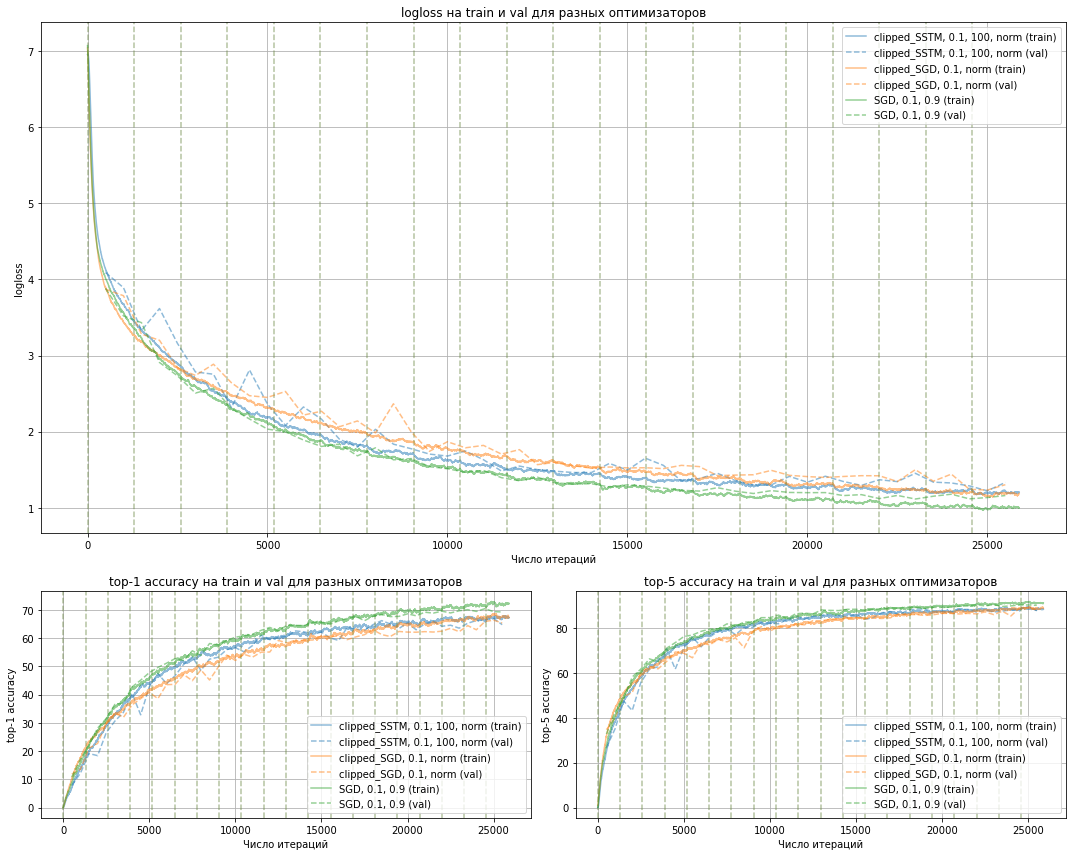

Finished Training


In [12]:
from IPython import display


for epoch in range(20):  # loop over the dataset multiple times
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        total_steps = net_hist["total_steps"]
        net_hist["epochs_x"].append(total_steps)

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            net_hist["train_loss"].append(loss.detach().cpu())
            net_hist["train_x"].append(total_steps)

            top_1, top_5 = accuracy(outputs.data, labels.data, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu())

            # print statistics
            if total_steps % 10 == 9:
                if total_steps % 500 == 499:
                    net.eval()

                    imgs_to_print = []
                    val_losses =  []
                    val_top_1_accs = []
                    val_top_5_accs = []

                    for val_data in val_loader:
                        inputs, labels = val_data[0].to(device), val_data[1].to(device)
                        outputs = net(inputs)
                        val_losses.append(criterion(outputs, labels).detach().cpu())

                        top_1, top_5 = accuracy(outputs.data, labels.data, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu())
                        val_top_5_accs.append(top_5.detach().cpu())

                    net_hist["val_loss"].append(np.mean(val_losses))
                    net_hist["val_x"].append(total_steps)

                    net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                    net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))

                    net.train()

                display.clear_output(wait=True)

                fig = plt.figure(figsize=(15, 12))
                gs=GridSpec(3,2, figure=fig)

                ax1=fig.add_subplot(gs[0:2,:])
                ax2=fig.add_subplot(gs[2,0])
                ax3=fig.add_subplot(gs[2,1])

                ax1=make_loss_plot(ax1, hist, eps=0.01)
                ax2=make_accuracy_plot(ax2, hist, eps=0.01, top_k=1)
                ax3=make_accuracy_plot(ax3, hist, eps=0.01, top_k=5)

                plt.tight_layout()
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
    print('Finished Training')

Сохраняем модели и данные для графиков

In [13]:
from datetime import datetime

now = datetime.now()
now = str(now)

for i in range(len(nets)):
    PATH = './models/{}.pth'.format(
        "_".join(now.split(" ")[1].split(".")[0].split(":") + hist[i]["name"].split())
    )
    torch.save(nets[0].state_dict(), PATH)

In [19]:
hist2 = hist.copy()

In [40]:
hist3 = []
for h in hist2:
    hist3.append({})
    for key in h:
        hist3[-1][key] = h[key]
        if isinstance(hist3[-1][key], list):
            if isinstance(hist3[-1][key][0], torch.Tensor):
                for i in range(len(hist3[-1][key])):
                    hist3[-1][key][i] = hist3[-1][key][i].numpy()
            if isinstance(hist3[-1][key][0], np.ndarray):
                for i in range(len(hist3[-1][key])):
                    hist3[-1][key][i] = np.asscalar(hist3[-1][key][i])
            for i in range(len(hist3[-1][key])):
                hist3[-1][key][i] = str(hist3[-1][key][i])

In [42]:
import json
with open('./models/{}_train_hist.json'.format("_".join(now.split(" ")[1].split(".")[0].split(":")))
          , 'w') as fout:
    json.dump(hist , fout)
    
# with open(r"/home/ubuntu/test.json", "r") as read_file:
#     data = json.load(read_file)

In [14]:
# Проверка на битые изображения

# a = datasets.ImageFolder(valdir)

# for i in range(0, 5000):
#     try:
#         a.__getitem__(i)
#     except:
#         print(i)

Можно еще загрузить и проверить

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


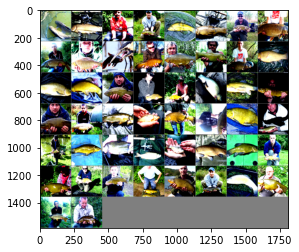

GroundTruth:      1     1     1     1


In [28]:
dataiter = iter(val_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [29]:
net = models.resnet18()
net.load_state_dict(torch.load("./models/13_16_32_SGD,_0.1,_0.9.pth"))

net.to(device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      1     1     1     1


In [18]:
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [26]:
correct = 0
total = 0
top_1_accuracy = []
top_5_accuracy = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images.to(device))
        top_1, top_5 = accuracy(outputs.data, labels.to(device).data, topk=(1, 5))
        top_1_accuracy.append(top_1.detach().cpu())
        top_5_accuracy.append(top_5.detach().cpu())

print('Top-1 accuracy of the network: %d %%' % (
    np.mean(top_1_accuracy)))
print('Top-5 accuracy of the network: %d %%' % (
    np.mean(top_5_accuracy)))

Top-1 accuracy of the network: 34 %
Top-5 accuracy of the network: 63 %


### Temp

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(100):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 76 %
Accuracy of  bird : 51 %
Accuracy of   cat : 36 %
Accuracy of  deer : 53 %
Accuracy of   dog : 57 %
Accuracy of  frog : 79 %
Accuracy of horse : 72 %
Accuracy of  ship : 69 %
Accuracy of truck : 71 %


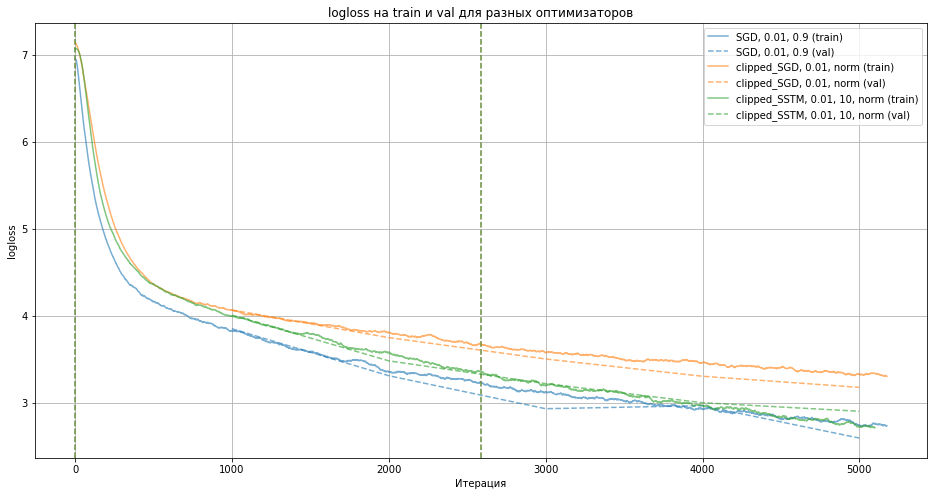

Finished Training


In [12]:
from IPython import display

for (net, optimizer, opt_name) in zip(nets, opts, opt_names):
    hist.append({
        "name": opt_name, 
        "train_loss": [], "train_x": [], 
        "val_loss": [], "val_x": [], 
        "train_acc_top_1": [], "train_acc_top_5": [], 
        "val_acc_top_1": [], "val_acc_top_5": [], 
        "epochs_x": []
    })
    net.to(device)
    total_steps = 0
    for epoch in range(2):  # loop over the dataset multiple times
        hist[-1]["epochs_x"].append(total_steps)

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            hist[-1]["train_loss"].append(loss.detach().cpu())
            hist[-1]["train_x"].append(total_steps)

            top_1, top_5 = accuracy(outputs.data, labels.data, topk=(1, 5))
            hist[-1]["train_acc_top_1"].append(top_1)
            hist[-1]["train_acc_top_5"].append(top_5)

            # print statistics
            if total_steps % 100 == 99:
                if total_steps % 1000 == 999:
                    net.eval()

                    imgs_to_print = []
                    val_losses =  []
                    val_top_1_accs = []
                    val_top_5_accs = []

                    for val_data in val_loader:
                        inputs, labels = val_data[0].to(device), val_data[1].to(device)
                        outputs = net(inputs)
                        val_losses.append(criterion(outputs, labels).detach().cpu())

                        top_1, top_5 = accuracy(outputs.data, labels.data, topk=(1, 5))
                        val_top_1_accs.append(top_1)
                        val_top_5_accs.append(top_5)

                    hist[-1]["val_loss"].append(np.mean(val_losses))
                    hist[-1]["val_x"].append(total_steps)

                    hist[-1]["train_acc_top_1"].append(np.mean(val_top_1_accs))
                    hist[-1]["train_acc_top_5"].append(np.mean(val_top_5_accs))

                    net.train()

                display.clear_output(wait=True)

                fig, axs = plt.subplots(1, 2, figsize=(16, 16))

                axs = make_plot(axs, hist, eps=0.01)

                plt.tight_layout()
                plt.draw()
                plt.show()

            total_steps += 1
    print('Finished Training')